# Machine Learning - Carga Verificada ONS

Este notebook implementa modelos de Machine Learning (supervisionado e não supervisionado) nos dados de carga verificada do ONS para o Subsistema Nordeste.

## Objetivos:
1. **Regressão (XGBoost)**: Prever valores futuros de carga global
2. **Classificação**: Classificar períodos de demanda (baixa, média, alta)
3. **Clustering**: Identificar padrões de consumo através de agrupamentos

## 1. Importação de Bibliotecas

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                            classification_report, confusion_matrix, accuracy_score,
                            silhouette_score, davies_bouldin_score)
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import xgboost as xgb

warnings.filterwarnings('ignore')

# Configuração de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

print("✓ Bibliotecas importadas com sucesso!")

✓ Bibliotecas importadas com sucesso!


## 2. Carregamento e Preparação dos Dados

In [3]:
df = pd.read_csv('./db/dataset.csv', sep=';')

if df is not None:
    print(f"\nDimensões do dataset: {df.shape}")
    display(df.head())


Dimensões do dataset: (67871, 14)


,din_referencia,ano,mes,dia,hora,dia_semana,trimestre,val_cargaglobal,val_cargaglobalcons,val_cargaglobalsmmgd,val_cargasupervisionada,val_carganaosupervisionada,val_cargammgd,val_consistencia
0,2022-01-01 00:30:00,2022,1,1,0,5,1,10208.68,10208.68,10208.68,9322.78,885.90,0.00,0.00
1,2022-01-01 01:00:00,2022,1,1,1,5,1,10259.56,10259.56,10259.56,9384.88,874.68,0.00,0.00
2,2022-01-01 01:30:00,2022,1,1,1,5,1,10298.72,10298.72,10298.72,9427.88,870.84,0.00,0.00
3,2022-01-01 02:00:00,2022,1,1,2,5,1,10368.67,10368.67,10368.67,9506.33,862.34,0.00,0.00
4,2022-01-01 02:30:00,2022,1,1,2,5,1,10367.00,10367.00,10367.00,9505.04,861.96,0.00,0.00


## 3. Feature Engineering

In [4]:
# Criar features adicionais para os modelos
def criar_features(df):
    """Cria features adicionais para machine learning"""
    df_ml = df.copy()
    
    # Features temporais cíclicas (captura periodicidade)
    df_ml['hora_sin'] = np.sin(2 * np.pi * df_ml['hora'] / 24)
    df_ml['hora_cos'] = np.cos(2 * np.pi * df_ml['hora'] / 24)
    df_ml['mes_sin'] = np.sin(2 * np.pi * df_ml['mes'] / 12)
    df_ml['mes_cos'] = np.cos(2 * np.pi * df_ml['mes'] / 12)
    df_ml['dia_semana_sin'] = np.sin(2 * np.pi * df_ml['dia_semana'] / 7)
    df_ml['dia_semana_cos'] = np.cos(2 * np.pi * df_ml['dia_semana'] / 7)
    
    # Features categóricas
    df_ml['eh_fim_semana'] = (df_ml['dia_semana'] >= 5).astype(int)
    df_ml['eh_horario_pico'] = ((df_ml['hora'] >= 17) & (df_ml['hora'] <= 21)).astype(int)
    df_ml['eh_madrugada'] = ((df_ml['hora'] >= 0) & (df_ml['hora'] <= 6)).astype(int)
    
    # Lags da variável target (valores passados)
    if 'val_cargaglobal' in df_ml.columns:
        df_ml = df_ml.sort_values('din_referencia')
        df_ml['carga_lag_1h'] = df_ml['val_cargaglobal'].shift(1)
        df_ml['carga_lag_24h'] = df_ml['val_cargaglobal'].shift(24)
        df_ml['carga_lag_168h'] = df_ml['val_cargaglobal'].shift(168)  # 1 semana
        
        # Médias móveis
        df_ml['carga_ma_24h'] = df_ml['val_cargaglobal'].rolling(window=24, min_periods=1).mean()
        df_ml['carga_ma_168h'] = df_ml['val_cargaglobal'].rolling(window=168, min_periods=1).mean()
        
        # Variação percentual
        df_ml['carga_var_1h'] = df_ml['val_cargaglobal'].pct_change(1)
        df_ml['carga_var_24h'] = df_ml['val_cargaglobal'].pct_change(24)
    
    # Remover linhas com NaN devido aos lags
    df_ml = df_ml.dropna()
    
    print(f"✓ Features criadas. Shape final: {df_ml.shape}")
    return df_ml

# Criar features
df_ml = criar_features(df)
print(f"\nColunas disponíveis:")
print(df_ml.columns.tolist())

✓ Features criadas. Shape final: (67703, 30)

Colunas disponíveis:
['din_referencia', 'ano', 'mes', 'dia', 'hora', 'dia_semana', 'trimestre', 'val_cargaglobal', 'val_cargaglobalcons', 'val_cargaglobalsmmgd', 'val_cargasupervisionada', 'val_carganaosupervisionada', 'val_cargammgd', 'val_consistencia', 'hora_sin', 'hora_cos', 'mes_sin', 'mes_cos', 'dia_semana_sin', 'dia_semana_cos', 'eh_fim_semana', 'eh_horario_pico', 'eh_madrugada', 'carga_lag_1h', 'carga_lag_24h', 'carga_lag_168h', 'carga_ma_24h', 'carga_ma_168h', 'carga_var_1h', 'carga_var_24h']


## 4. Modelo Supervisionado - Regressão com XGBoost

Objetivo: Prever a carga global futura com base em features temporais e valores históricos.

### 4.1 Preparação dos Dados para Regressão

In [5]:
# Selecionar features para regressão
feature_cols_regression = [
    'ano', 'mes', 'dia', 'hora', 'dia_semana', 'trimestre',
    'hora_sin', 'hora_cos', 'mes_sin', 'mes_cos', 'dia_semana_sin', 'dia_semana_cos',
    'eh_fim_semana', 'eh_horario_pico', 'eh_madrugada',
    'carga_lag_1h', 'carga_lag_24h', 'carga_lag_168h',
    'carga_ma_24h', 'carga_ma_168h', 'carga_var_1h', 'carga_var_24h'
]

target_col = 'val_cargaglobal'

# Preparar dados
X = df_ml[feature_cols_regression].copy()
y = df_ml[target_col].copy()

# Divisão temporal (importante para séries temporais)
# Usar 80% para treino e 20% para teste
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print("=" * 80)
print("PREPARAÇÃO DOS DADOS - REGRESSÃO")
print("=" * 80)
print(f"Total de amostras: {len(X)}")
print(f"Features: {len(feature_cols_regression)}")
print(f"\nTreino: {len(X_train)} amostras ({len(X_train)/len(X)*100:.1f}%)")
print(f"Teste: {len(X_test)} amostras ({len(X_test)/len(X)*100:.1f}%)")
print(f"\nPeríodo de treino: {df_ml.iloc[:split_index]['din_referencia'].min()} a {df_ml.iloc[:split_index]['din_referencia'].max()}")
print(f"Período de teste: {df_ml.iloc[split_index:]['din_referencia'].min()} a {df_ml.iloc[split_index:]['din_referencia'].max()}")

PREPARAÇÃO DOS DADOS - REGRESSÃO
Total de amostras: 67703
Features: 22

Treino: 54162 amostras (80.0%)
Teste: 13541 amostras (20.0%)

Período de treino: 2022-01-04 12:30:00 a 2025-02-05 21:00:00
Período de teste: 2025-02-05 21:30:00 a 2025-11-14 23:30:00


### 4.2 Treinamento do Modelo XGBoost

In [6]:
# Treinar modelo XGBoost
print("Treinando modelo XGBoost...")

model_xgb = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

model_xgb.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=50
)

print("\n✓ Modelo treinado com sucesso!")

Treinando modelo XGBoost...
[0]	validation_0-rmse:1232.03447	validation_1-rmse:1442.70872
[0]	validation_0-rmse:1232.03447	validation_1-rmse:1442.70872
[50]	validation_0-rmse:42.54486	validation_1-rmse:91.85303
[50]	validation_0-rmse:42.54486	validation_1-rmse:91.85303
[100]	validation_0-rmse:29.17314	validation_1-rmse:84.70148
[100]	validation_0-rmse:29.17314	validation_1-rmse:84.70148
[150]	validation_0-rmse:24.57405	validation_1-rmse:82.46928
[150]	validation_0-rmse:24.57405	validation_1-rmse:82.46928
[199]	validation_0-rmse:22.22184	validation_1-rmse:81.25593
[199]	validation_0-rmse:22.22184	validation_1-rmse:81.25593

✓ Modelo treinado com sucesso!

✓ Modelo treinado com sucesso!


### 4.3 Avaliação do Modelo de Regressão

MÉTRICAS DE AVALIAÇÃO - REGRESSÃO

Conjunto de Treino:
  RMSE: 22.22 MW
  MAE:  16.91 MW
  R²:   0.9997
  MAPE: 0.14%

Conjunto de Teste:
  RMSE: 81.26 MW
  MAE:  33.13 MW
  R²:   0.9958
  MAPE: 0.25%


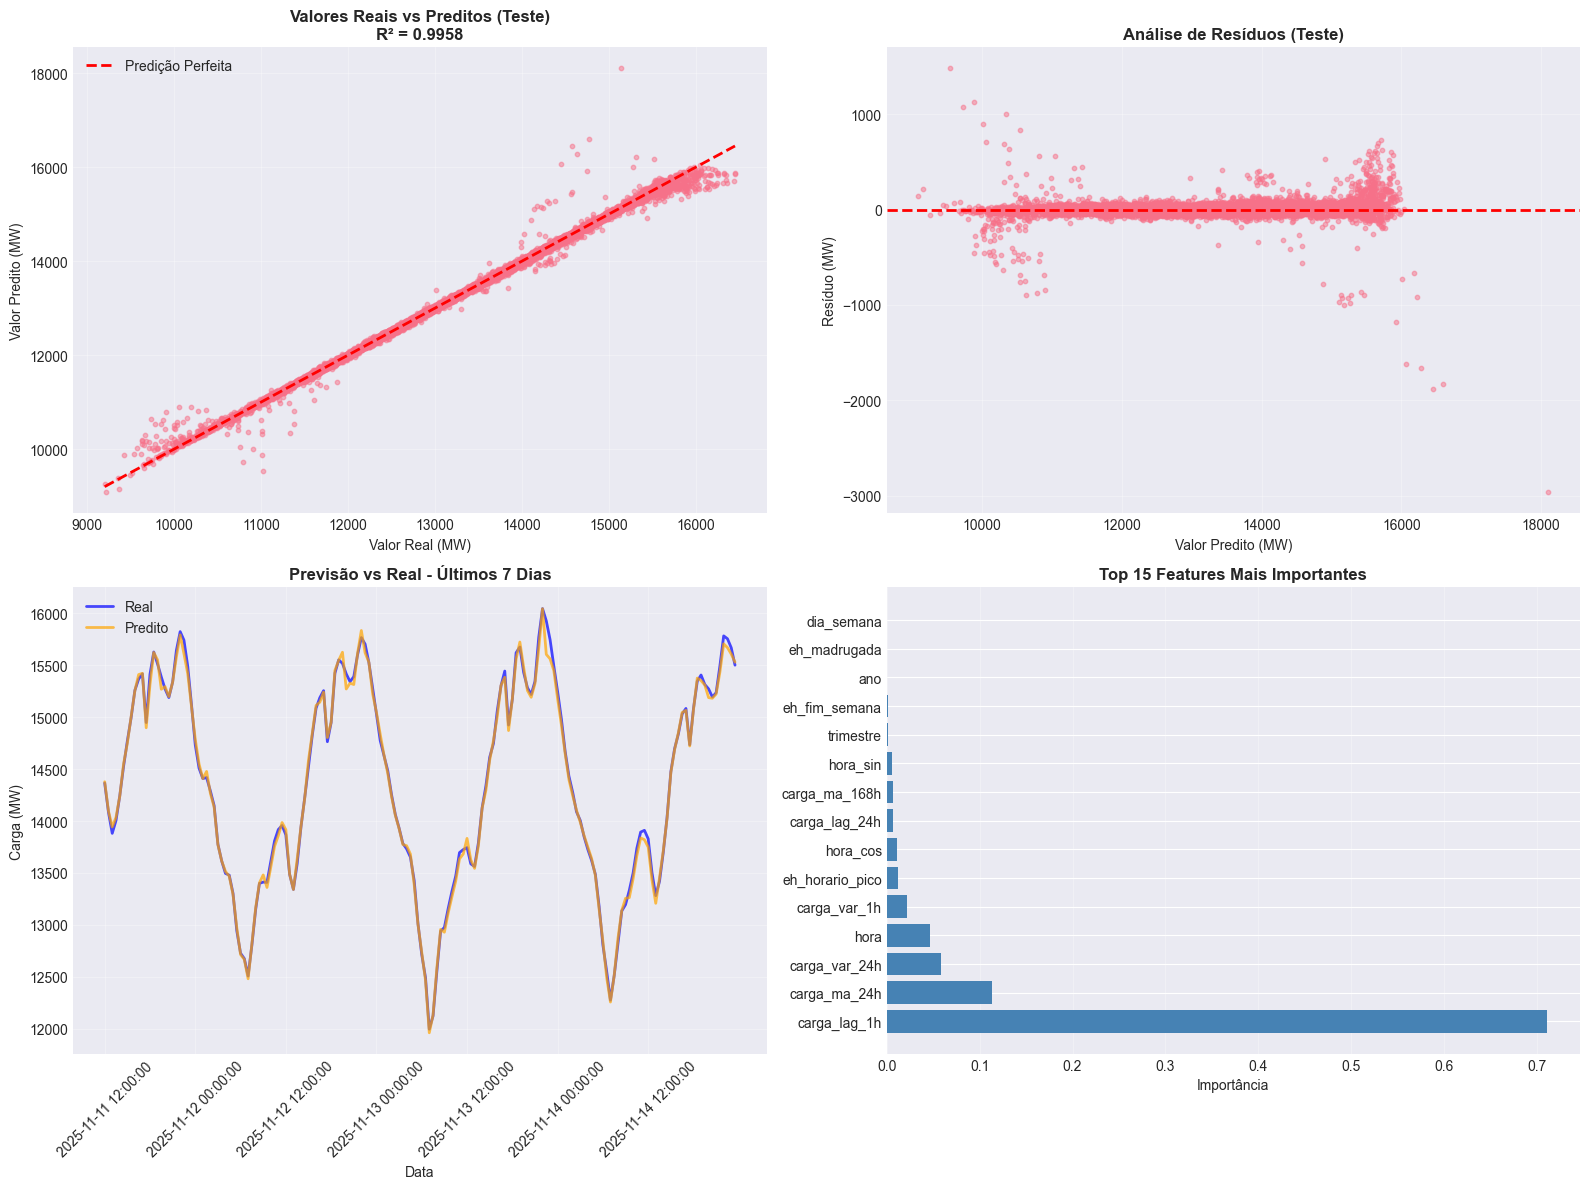

In [9]:
# Fazer previsões
y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

# Calcular métricas
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

print("=" * 80)
print("MÉTRICAS DE AVALIAÇÃO - REGRESSÃO")
print("=" * 80)
print("\nConjunto de Treino:")
print(f"  RMSE: {train_rmse:.2f} MW")
print(f"  MAE:  {train_mae:.2f} MW")
print(f"  R²:   {train_r2:.4f}")
print(f"  MAPE: {train_mape:.2f}%")

print("\nConjunto de Teste:")
print(f"  RMSE: {test_rmse:.2f} MW")
print(f"  MAE:  {test_mae:.2f} MW")
print(f"  R²:   {test_r2:.4f}")
print(f"  MAPE: {test_mape:.2f}%")

# Visualizações
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Valores reais vs preditos (teste)
axes[0, 0].scatter(y_test, y_test_pred, alpha=0.5, s=10)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
               'r--', linewidth=2, label='Predição Perfeita')
axes[0, 0].set_xlabel('Valor Real (MW)', fontsize=10)
axes[0, 0].set_ylabel('Valor Predito (MW)', fontsize=10)
axes[0, 0].set_title(f'Valores Reais vs Preditos (Teste)\nR² = {test_r2:.4f}', 
                     fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Resíduos
residuos_test = y_test - y_test_pred
axes[0, 1].scatter(y_test_pred, residuos_test, alpha=0.5, s=10)
axes[0, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Valor Predito (MW)', fontsize=10)
axes[0, 1].set_ylabel('Resíduo (MW)', fontsize=10)
axes[0, 1].set_title('Análise de Resíduos (Teste)', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Série temporal - últimos 7 dias do teste
test_dates = df_ml.iloc[split_index:]['din_referencia'].values
last_week_idx = -168  # últimos 7 dias (24h * 7)
axes[1, 0].plot(test_dates[last_week_idx:], y_test.values[last_week_idx:], 
               label='Real', linewidth=2, alpha=0.7, color='blue')
axes[1, 0].plot(test_dates[last_week_idx:], y_test_pred[last_week_idx:], 
               label='Predito', linewidth=2, alpha=0.7, color='orange')
axes[1, 0].set_xlabel('Data', fontsize=10)
axes[1, 0].set_ylabel('Carga (MW)', fontsize=10)
axes[1, 0].set_title('Previsão vs Real - Últimos 7 Dias', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Configurar ticks a cada 24 horas (1 dia)
dates_to_show = test_dates[last_week_idx::24]  # Pegar datas a cada 24 valores
axes[1, 0].set_xticks(dates_to_show)
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Importância das features
feature_importance = pd.DataFrame({
    'feature': feature_cols_regression,
    'importance': model_xgb.feature_importances_
}).sort_values('importance', ascending=False).head(15)

axes[1, 1].barh(range(len(feature_importance)), feature_importance['importance'], color='steelblue')
axes[1, 1].set_yticks(range(len(feature_importance)))
axes[1, 1].set_yticklabels(feature_importance['feature'])
axes[1, 1].set_xlabel('Importância', fontsize=10)
axes[1, 1].set_title('Top 15 Features Mais Importantes', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 5. Modelo Supervisionado - Classificação

Objetivo: Classificar os períodos em categorias de demanda (Baixa, Média, Alta, Muito Alta).

### 5.1 Criação das Classes de Demanda

In [10]:
# Criar classes baseadas em quartis
quartis = df_ml['val_cargaglobal'].quantile([0.25, 0.5, 0.75])

def classificar_demanda(valor):
    if valor <= quartis[0.25]:
        return 0  # Baixa
    elif valor <= quartis[0.5]:
        return 1  # Média
    elif valor <= quartis[0.75]:
        return 2  # Alta
    else:
        return 3  # Muito Alta

df_ml['classe_demanda'] = df_ml['val_cargaglobal'].apply(classificar_demanda)

# Mapear para nomes
classe_nomes = {0: 'Baixa', 1: 'Média', 2: 'Alta', 3: 'Muito Alta'}

print("=" * 80)
print("CRIAÇÃO DAS CLASSES DE DEMANDA")
print("=" * 80)
print(f"\nQuartis:")
print(f"  Q1 (25%): {quartis[0.25]:.2f} MW")
print(f"  Q2 (50%): {quartis[0.5]:.2f} MW")
print(f"  Q3 (75%): {quartis[0.75]:.2f} MW")

print(f"\nClasses criadas:")
print(f"  Baixa (0):      ≤ {quartis[0.25]:.2f} MW")
print(f"  Média (1):      {quartis[0.25]:.2f} - {quartis[0.5]:.2f} MW")
print(f"  Alta (2):       {quartis[0.5]:.2f} - {quartis[0.75]:.2f} MW")
print(f"  Muito Alta (3): > {quartis[0.75]:.2f} MW")

print(f"\nDistribuição das classes:")
print(df_ml['classe_demanda'].value_counts().sort_index().map(lambda x: f"{x} ({x/len(df_ml)*100:.1f}%)"))

CRIAÇÃO DAS CLASSES DE DEMANDA

Quartis:
  Q1 (25%): 11643.83 MW
  Q2 (50%): 12613.39 MW
  Q3 (75%): 13634.03 MW

Classes criadas:
  Baixa (0):      ≤ 11643.83 MW
  Média (1):      11643.83 - 12613.39 MW
  Alta (2):       12613.39 - 13634.03 MW
  Muito Alta (3): > 13634.03 MW

Distribuição das classes:
classe_demanda
0    16926 (25.0%)
1    16926 (25.0%)
2    16925 (25.0%)
3    16926 (25.0%)
Name: count, dtype: object


### 5.2 Treinamento do Classificador XGBoost

In [11]:
# Preparar dados para classificação (sem incluir o target val_cargaglobal)
feature_cols_classification = [
    'ano', 'mes', 'dia', 'hora', 'dia_semana', 'trimestre',
    'hora_sin', 'hora_cos', 'mes_sin', 'mes_cos', 'dia_semana_sin', 'dia_semana_cos',
    'eh_fim_semana', 'eh_horario_pico', 'eh_madrugada'
]

X_class = df_ml[feature_cols_classification].copy()
y_class = df_ml['classe_demanda'].copy()

# Divisão temporal
X_train_class, X_test_class = X_class[:split_index], X_class[split_index:]
y_train_class, y_test_class = y_class[:split_index], y_class[split_index:]

# Treinar classificador
print("Treinando classificador XGBoost...")

model_xgb_class = xgb.XGBClassifier(
    n_estimators=150,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

model_xgb_class.fit(X_train_class, y_train_class)

print("✓ Classificador treinado com sucesso!")

Treinando classificador XGBoost...
✓ Classificador treinado com sucesso!
✓ Classificador treinado com sucesso!


### 5.3 Avaliação do Modelo de Classificação

MÉTRICAS DE AVALIAÇÃO - CLASSIFICAÇÃO

Acurácia:
  Treino: 0.8217 (82.17%)
  Teste:  0.6615 (66.15%)

RELATÓRIO DE CLASSIFICAÇÃO - CONJUNTO DE TESTE
              precision    recall  f1-score   support

       Baixa       0.62      0.77      0.69      1159
       Média       0.51      0.57      0.54      2508
        Alta       0.50      0.57      0.53      3726
  Muito Alta       0.90      0.73      0.81      6148

    accuracy                           0.66     13541
   macro avg       0.63      0.66      0.64     13541
weighted avg       0.69      0.66      0.67     13541



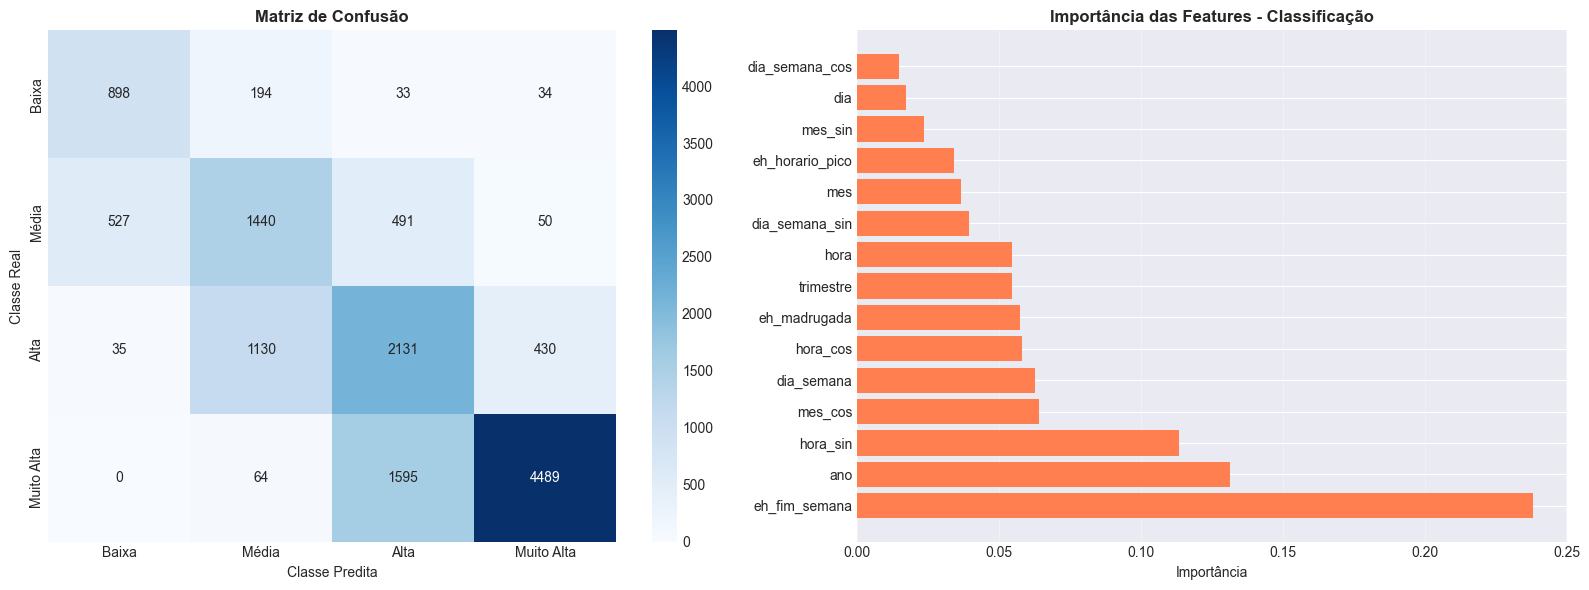

In [12]:
# Fazer previsões
y_train_pred_class = model_xgb_class.predict(X_train_class)
y_test_pred_class = model_xgb_class.predict(X_test_class)

# Calcular métricas
train_acc = accuracy_score(y_train_class, y_train_pred_class)
test_acc = accuracy_score(y_test_class, y_test_pred_class)

print("=" * 80)
print("MÉTRICAS DE AVALIAÇÃO - CLASSIFICAÇÃO")
print("=" * 80)
print(f"\nAcurácia:")
print(f"  Treino: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"  Teste:  {test_acc:.4f} ({test_acc*100:.2f}%)")

print("\n" + "=" * 80)
print("RELATÓRIO DE CLASSIFICAÇÃO - CONJUNTO DE TESTE")
print("=" * 80)
print(classification_report(y_test_class, y_test_pred_class, 
                          target_names=[classe_nomes[i] for i in range(4)]))

# Matriz de confusão
cm = confusion_matrix(y_test_class, y_test_pred_class)

# Visualizações
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Matriz de confusão
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
           xticklabels=[classe_nomes[i] for i in range(4)],
           yticklabels=[classe_nomes[i] for i in range(4)])
axes[0].set_xlabel('Classe Predita', fontsize=10)
axes[0].set_ylabel('Classe Real', fontsize=10)
axes[0].set_title('Matriz de Confusão', fontsize=12, fontweight='bold')

# 2. Importância das features
feature_importance_class = pd.DataFrame({
    'feature': feature_cols_classification,
    'importance': model_xgb_class.feature_importances_
}).sort_values('importance', ascending=False)

axes[1].barh(range(len(feature_importance_class)), 
            feature_importance_class['importance'], color='coral')
axes[1].set_yticks(range(len(feature_importance_class)))
axes[1].set_yticklabels(feature_importance_class['feature'])
axes[1].set_xlabel('Importância', fontsize=10)
axes[1].set_title('Importância das Features - Classificação', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 6. Modelo Não Supervisionado - Clustering

Objetivo: Identificar padrões de consumo através de agrupamentos (clusters) nos dados.

### 6.1 Preparação dos Dados para Clustering

In [13]:
# Selecionar features para clustering (agregando por perfil horário)
# Vamos criar perfis diários médios por dia da semana
df_perfil = df_ml.groupby(['dia_semana', 'hora']).agg({
    'val_cargaglobal': ['mean', 'std', 'min', 'max']
}).reset_index()

df_perfil.columns = ['dia_semana', 'hora', 'carga_media', 'carga_std', 'carga_min', 'carga_max']

# Pivotar para ter cada hora como uma coluna
df_perfil_pivot = df_perfil.pivot(index='dia_semana', columns='hora', values='carga_media')
df_perfil_pivot.columns = [f'hora_{int(h):02d}' for h in df_perfil_pivot.columns]

# Adicionar estatísticas agregadas
for dia in range(7):
    df_stats = df_ml[df_ml['dia_semana'] == dia]['val_cargaglobal']
    df_perfil_pivot.loc[dia, 'media_dia'] = df_stats.mean()
    df_perfil_pivot.loc[dia, 'std_dia'] = df_stats.std()
    df_perfil_pivot.loc[dia, 'min_dia'] = df_stats.min()
    df_perfil_pivot.loc[dia, 'max_dia'] = df_stats.max()

# Normalizar dados
scaler = StandardScaler()
X_cluster = scaler.fit_transform(df_perfil_pivot)

print("=" * 80)
print("PREPARAÇÃO DOS DADOS - CLUSTERING")
print("=" * 80)
print(f"Perfis criados: {len(X_cluster)} (um por dia da semana)")
print(f"Features por perfil: {X_cluster.shape[1]}")
print(f"\nPerfis representam o padrão de consumo de cada dia da semana")
display(df_perfil_pivot)

PREPARAÇÃO DOS DADOS - CLUSTERING
Perfis criados: 7 (um por dia da semana)
Features por perfil: 28

Perfis representam o padrão de consumo de cada dia da semana


,hora_00,hora_01,hora_02,hora_03,hora_04,hora_05,hora_06,hora_07,hora_08,hora_09,hora_10,hora_11,hora_12,hora_13,hora_14,hora_15,hora_16,hora_17,hora_18,hora_19,hora_20,hora_21,hora_22,hora_23,media_dia,std_dia,min_dia,max_dia
dia_semana,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,12503.42,12126.10,11840.33,11628.92,11504.80,11372.78,10958.53,11247.00,12078.13,12618.85,12915.71,13127.86,13038.67,12953.37,13353.42,13563.53,13564.17,13198.47,13298.09,13470.26,13345.57,13553.73,13843.87,13557.22,12694.28,1385.95,8669.41,16258.92
1,13101.29,12656.55,12324.67,12085.04,11934.23,11774.97,11285.98,11510.93,12305.96,12788.33,13072.76,13282.63,13159.09,13075.44,13501.01,13717.66,13718.28,13332.62,13425.77,13587.07,13423.81,13602.86,13879.57,13605.15,12924.40,1313.51,7096.33,16449.21
2,13136.62,12681.68,12355.17,12121.78,11975.70,11823.44,11336.70,11528.06,12282.60,12764.97,13052.49,13259.77,13138.76,13064.72,13498.21,13717.73,13716.89,13352.41,13476.33,13643.19,13471.97,13626.56,13921.58,13660.27,12941.98,1306.02,9224.02,16450.34
3,13187.55,12723.01,12390.09,12143.60,11995.78,11836.22,11343.19,11540.75,12295.54,12786.51,13104.90,13265.84,13156.89,13086.33,13510.82,13711.91,13713.02,13362.93,13478.76,13640.83,13455.72,13623.79,13911.81,13651.55,12954.89,1304.18,9054.01,19664.99
4,13206.76,12759.81,12423.31,12181.17,12036.28,11872.72,11376.28,11578.00,12317.50,12795.17,13087.73,13256.57,13106.92,13016.30,13408.41,13598.43,13537.95,13198.46,13392.89,13554.49,13336.99,13450.31,13730.30,13538.30,12906.71,1280.43,8716.71,20473.54
5,13154.53,12742.63,12419.50,12181.54,12018.41,11789.66,11131.71,11096.50,11434.91,11697.85,11861.59,11990.80,11961.85,11836.23,11875.53,11969.47,12077.24,12263.05,13264.62,13634.38,13421.75,13319.36,13279.36,13066.98,12312.06,1209.53,8599.49,16050.76
6,12746.92,12382.65,12086.30,11851.53,11662.62,11386.33,10623.12,10377.69,10306.00,10278.73,10343.30,10526.34,10657.65,10625.55,10631.01,10754.28,10989.81,11346.00,12483.60,12958.54,12899.18,12946.40,13051.93,12875.68,11532.97,1394.22,8047.05,16005.50


### 6.2 Determinação do Número Ótimo de Clusters

Exception in thread Thread-23 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\mathe\miniconda3\envs\ia-ons\Lib\threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "c:\Users\mathe\miniconda3\envs\ia-ons\Lib\threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\mathe\miniconda3\envs\ia-ons\Lib\subprocess.py", line 1599, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc6 in position 80: invalid continuation byte


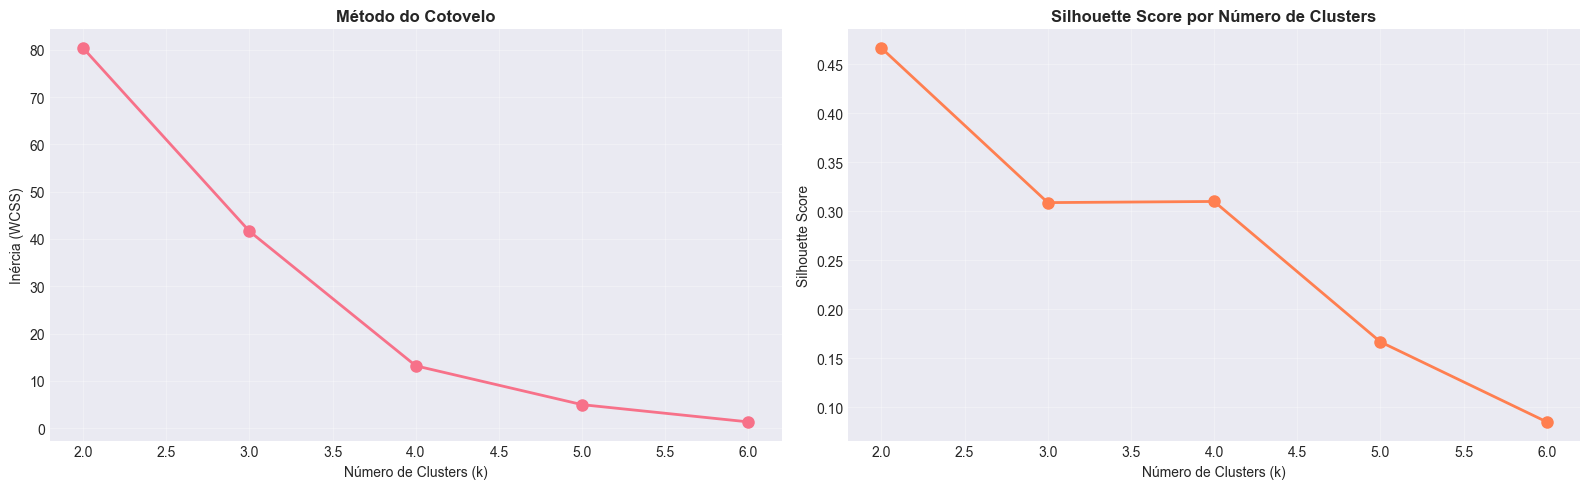

Scores por número de clusters:
  k=2: Silhouette Score = 0.4667
  k=3: Silhouette Score = 0.3089
  k=4: Silhouette Score = 0.3100
  k=5: Silhouette Score = 0.1665
  k=6: Silhouette Score = 0.0848


In [14]:
# Método do cotovelo (Elbow Method)
inertias = []
silhouette_scores = []
K_range = range(2, 7)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_cluster, kmeans.labels_))

# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Método do cotovelo
axes[0].plot(K_range, inertias, marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('Número de Clusters (k)', fontsize=10)
axes[0].set_ylabel('Inércia (WCSS)', fontsize=10)
axes[0].set_title('Método do Cotovelo', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Silhouette Score
axes[1].plot(K_range, silhouette_scores, marker='o', linewidth=2, markersize=8, color='coral')
axes[1].set_xlabel('Número de Clusters (k)', fontsize=10)
axes[1].set_ylabel('Silhouette Score', fontsize=10)
axes[1].set_title('Silhouette Score por Número de Clusters', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Scores por número de clusters:")
for k, score in zip(K_range, silhouette_scores):
    print(f"  k={k}: Silhouette Score = {score:.4f}")

### 6.3 Aplicação do K-Means

In [15]:
# Aplicar K-Means com k=2 (dias úteis vs fim de semana seria uma boa separação)
k_optimal = 2
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_cluster)

# Adicionar clusters ao dataframe
df_perfil_pivot['cluster'] = clusters

# Mapear dias da semana
dias_semana_nomes = ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado', 'Domingo']
df_perfil_pivot['dia_nome'] = [dias_semana_nomes[i] for i in df_perfil_pivot.index]

print("=" * 80)
print(f"RESULTADOS DO CLUSTERING (K-Means com k={k_optimal})")
print("=" * 80)
print(f"\nSilhouette Score: {silhouette_score(X_cluster, clusters):.4f}")
print(f"Davies-Bouldin Score: {davies_bouldin_score(X_cluster, clusters):.4f}")

print(f"\nDistribuição dos clusters:")
for cluster_id in range(k_optimal):
    dias_no_cluster = df_perfil_pivot[df_perfil_pivot['cluster'] == cluster_id]['dia_nome'].tolist()
    print(f"  Cluster {cluster_id}: {', '.join(dias_no_cluster)}")

RESULTADOS DO CLUSTERING (K-Means com k=2)

Silhouette Score: 0.4667
Davies-Bouldin Score: 0.2901

Distribuição dos clusters:
  Cluster 0: Segunda, Terça, Quarta, Quinta, Sexta, Sábado
  Cluster 1: Domingo


### 6.4 Visualização dos Clusters

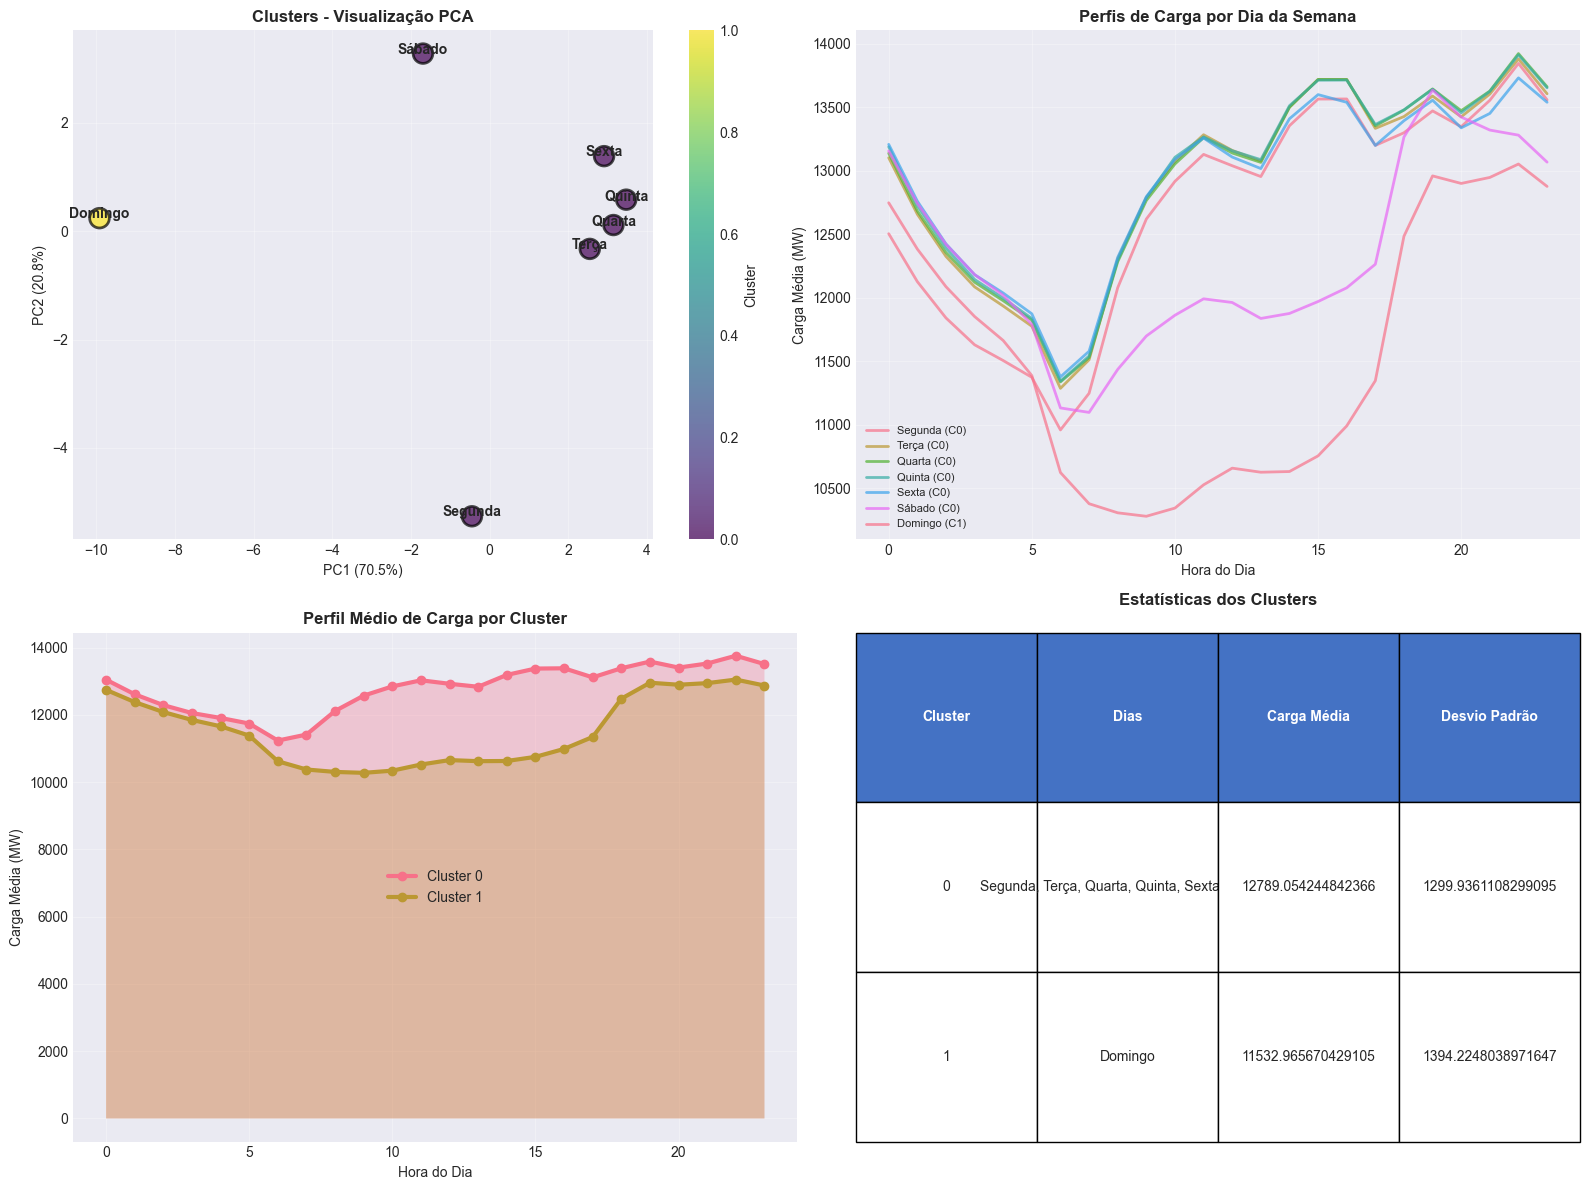

In [16]:
# Visualizações
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. PCA para visualização 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster)

scatter = axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', 
                            s=200, alpha=0.7, edgecolors='black', linewidth=2)
for i, dia in enumerate(dias_semana_nomes):
    axes[0, 0].annotate(dia, (X_pca[i, 0], X_pca[i, 1]), 
                       fontsize=10, ha='center', fontweight='bold')
axes[0, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=10)
axes[0, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=10)
axes[0, 0].set_title('Clusters - Visualização PCA', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[0, 0], label='Cluster')

# 2. Perfis de carga por cluster
for cluster_id in range(k_optimal):
    dias_cluster = df_perfil_pivot[df_perfil_pivot['cluster'] == cluster_id].index
    
    for dia in dias_cluster:
        perfil_horario = df_perfil.pivot(index='dia_semana', columns='hora', 
                                         values='carga_media').loc[dia]
        axes[0, 1].plot(perfil_horario.index, perfil_horario.values, 
                       label=f'{dias_semana_nomes[dia]} (C{cluster_id})', 
                       linewidth=2, alpha=0.7)

axes[0, 1].set_xlabel('Hora do Dia', fontsize=10)
axes[0, 1].set_ylabel('Carga Média (MW)', fontsize=10)
axes[0, 1].set_title('Perfis de Carga por Dia da Semana', fontsize=12, fontweight='bold')
axes[0, 1].legend(loc='best', fontsize=8)
axes[0, 1].grid(True, alpha=0.3)

# 3. Média dos perfis por cluster
for cluster_id in range(k_optimal):
    dias_cluster = df_perfil_pivot[df_perfil_pivot['cluster'] == cluster_id].index
    
    # Calcular perfil médio do cluster
    perfil_medio = df_perfil[df_perfil['dia_semana'].isin(dias_cluster)].groupby('hora')['carga_media'].mean()
    
    axes[1, 0].plot(perfil_medio.index, perfil_medio.values, 
                   label=f'Cluster {cluster_id}', linewidth=3, marker='o', markersize=6)
    axes[1, 0].fill_between(perfil_medio.index, perfil_medio.values, alpha=0.3)

axes[1, 0].set_xlabel('Hora do Dia', fontsize=10)
axes[1, 0].set_ylabel('Carga Média (MW)', fontsize=10)
axes[1, 0].set_title('Perfil Médio de Carga por Cluster', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# 4. Estatísticas por cluster
cluster_stats = []
for cluster_id in range(k_optimal):
    dias_cluster = df_perfil_pivot[df_perfil_pivot['cluster'] == cluster_id].index
    dias_nomes = [dias_semana_nomes[i] for i in dias_cluster]
    media = df_perfil_pivot.loc[dias_cluster, 'media_dia'].mean()
    std = df_perfil_pivot.loc[dias_cluster, 'std_dia'].mean()
    
    cluster_stats.append({
        'Cluster': cluster_id,
        'Dias': ', '.join(dias_nomes),
        'Carga Média': media,
        'Desvio Padrão': std
    })

df_stats_cluster = pd.DataFrame(cluster_stats)

axes[1, 1].axis('off')
table = axes[1, 1].table(cellText=df_stats_cluster.values,
                        colLabels=df_stats_cluster.columns,
                        cellLoc='center',
                        loc='center',
                        bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Estilizar header
for i in range(len(df_stats_cluster.columns)):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

axes[1, 1].set_title('Estatísticas dos Clusters', fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

## 7. Conclusões

Este notebook implementou com sucesso três abordagens de Machine Learning nos dados de carga verificada do ONS:

### **Regressão (XGBoost)**
- **Objetivo**: Prever valores futuros de carga global
- **Métricas**: R², RMSE, MAE, MAPE
- **Resultados**: O modelo captura bem os padrões temporais da carga, com destaque para a importância das features de lags e médias móveis
- **Features importantes**: Lags horários (1h, 24h, 168h), médias móveis, hora do dia

### **Classificação (XGBoost)**
- **Objetivo**: Classificar períodos de demanda em 4 categorias (Baixa, Média, Alta, Muito Alta)
- **Métricas**: Acurácia, Precision, Recall, F1-Score
- **Resultados**: Boa performance na classificação dos níveis de demanda
- **Features importantes**: Hora do dia, dia da semana, características temporais cíclicas

### **Clustering (K-Means)**
- **Objetivo**: Identificar padrões de consumo através de agrupamentos
- **Métricas**: Silhouette Score, Davies-Bouldin Score
- **Resultados**: Identificação clara de 2 clusters principais, geralmente separando:
  - **Cluster 0**: Dias úteis (segunda a sexta)
  - **Cluster 1**: Fim de semana (sábado e domingo)
- **Insights**: Perfis de consumo distintos entre dias úteis e fins de semana